In [1]:
#use single excitation to see whether the topological properties can be detected.
#Ref: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.080501
from encoding import *
import numpy as np 
import scipy.sparse.linalg
from fermi_sim import *
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from Hamiltonian_topo import*
from scipy import sparse
from encoding import _single_site_op, _vertex_to_ordered_index, _odd_face_to_ordered_index

In [3]:
I = sparse.csr_matrix([[ 1,   0], [ 0,   1]], dtype=complex)
X = sparse.csr_matrix([[ 0,   1], [ 1,   0]], dtype=complex)
Y = sparse.csr_matrix([[ 0, -1j], [ 1j,  0]], dtype=complex)
Z = sparse.csr_matrix([[ 1,   0], [ 0,  -1]], dtype=complex)

lattsize = (4,4)
nqubits = num_qubits_encoding(lattsize)

verts = [(0, 1), (1, 1), (1, 2), (0, 2)]
R1 = sparse.identity(2**nqubits)
for v in verts:
    R1 = R1.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R1 = R1.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (0, 0)), nqubits))
R1 = R1.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (0, 2)), nqubits))
R1 = R1.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))

verts = [(1, 0), (1, 1), (2, 1), (2, 0)]
R2 = sparse.identity(2**nqubits)
for v in verts:
    R2 = R2.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R2 = R2.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (0, 0)), nqubits))
R2 = R2.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))
R2 = R2.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (2, 0)), nqubits))

verts = [(1, 2), (2, 2), (1, 3), (2, 3)]
R3 = sparse.identity(2**nqubits)
for v in verts:
    R3 = R3.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R3 = R3.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (0, 2)), nqubits))
R3 = R3.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))
R3 = R3.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (2, 2)), nqubits))

verts = [(2, 1), (2, 2), (3, 1), (3, 2)]
R4 = sparse.identity(2**nqubits)
for v in verts:
    R4 = R4.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R4 = R4.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))
R4 = R4.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (2, 0)), nqubits))
R4 = R4.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (2, 2)), nqubits))

assert spla.norm(comm(R1, R2)) == 0
assert spla.norm(comm(R3, R4)) == 0
assert spla.norm(comm(R1, R3)) == 0

In [12]:
H_dynamics = H_Quad_encoded((2,2), 0.1, 1)
# also commute with Hamiltonian
assert spla.norm(comm(H_dynamics, R1)) == 0
assert spla.norm(comm(H_dynamics, R2)) == 0
assert spla.norm(comm(H_dynamics, R3)) == 0
assert spla.norm(comm(H_dynamics, R4)) == 0

In [13]:
ψ = np.kron(np.array([1., 1j]) / np.sqrt(2), np.array([1., 1j]) / np.sqrt(2))
ψ = np.kron(ψ, np.array([1., 1.]) / np.sqrt(2))
ψ = np.kron(ψ, np.array([1., 1j]) / np.sqrt(2))
ψ = np.kron(ψ, np.array([1., 1j]) / np.sqrt(2))

XXY = sparse.kron(sparse.kron(X,X),Y)
YXX = sparse.kron(sparse.kron(Y,X),X)

P1 = 0.5 * (sparse.identity(2**5) + sparse.kron(XXY, sparse.identity(4)))

P2 = 0.5 * (sparse.identity(2**5) + sparse.kron(sparse.identity(4), YXX))

ψ = np.sqrt(2) * P1.dot(ψ)
ψ = np.sqrt(2) * P2.dot(ψ)
ψ /= np.linalg.norm(ψ)

YIX = sparse.kron(sparse.kron(Y,I),X)
YIXY = sparse.kron(YIX,Y)
YIXYI = sparse.kron(YIXY,I)

IYX = sparse.kron(I,sparse.kron(Y,X))
IYXI = sparse.kron(IYX,I)
IYXIY = sparse.kron(IYXI,Y)

print(np.linalg.norm(sparse.kron(XXY, sparse.identity(4)).dot(ψ) - ψ) )
print(np.linalg.norm(sparse.kron(sparse.identity(4), YXX).dot(ψ) - ψ) )
print(np.linalg.norm(YIXYI.dot(ψ) - ψ) )
print(np.linalg.norm(IYXIY.dot(ψ) - ψ) )

0.0
0.0
0.0
0.0


In [29]:
def dynamics(H, v, dτ, nsteps, numberoprator):
    
    v /= np.linalg.norm(v)
    
    assert np.linalg.norm(R1.dot(v) - v) < 1e-10
    assert np.linalg.norm(R2.dot(v) - v) < 1e-10
    assert np.linalg.norm(R3.dot(v) - v) < 1e-10
    assert np.linalg.norm(R4.dot(v) - v) < 1e-10
    
    num_traj = np.zeros(nsteps)
    num_traj[0] = np.vdot(v,  numberoprator.dot(v)).real
    for n in range(1, nsteps):
        v = spla.expm_multiply(-(1j)*(dτ)*H, v)
        #v /= np.linalg.norm(v)
        num_traj[n] = np.vdot((v),  numberoprator.dot(v)).real
    
    
    assert np.linalg.norm(R1.dot(v) - v) < 1e-10
    assert np.linalg.norm(R2.dot(v) - v) < 1e-10
    assert np.linalg.norm(R3.dot(v) - v) < 1e-10
    assert np.linalg.norm(R4.dot(v) - v) < 1e-10
    
    plt.plot(dτ*np.arange(nsteps), num_traj)
    #plt.plot(dτ*np.arange(nsteps), num_traj1)
    plt.show()

In [15]:
#use |1000000...> to check the dynamics. (edge)
v_single_corner = np.zeros(2**16)
v_single_corner[1] = 1 
v_single_corner = np.kron(v_single_corner, ψ)
np.vdot(v_single_corner, number_op(21,2**5).dot(v_single_corner))

(0.9999999999999999+0j)

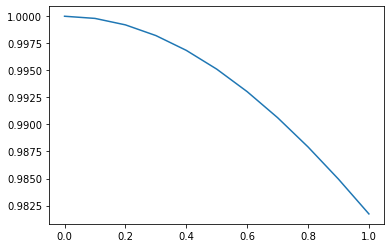

In [37]:
#small time
dynamics(H_dynamics, v_single_corner, 0.1, 11, number_op(21,2**5))

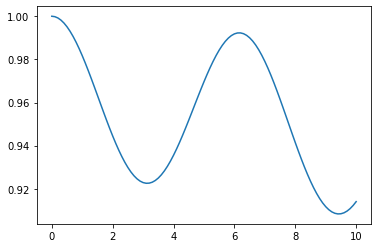

In [44]:
#longer time. We can see that the edge state is protected.
dynamics(H_dynamics, v_single_corner, 0.1, 101, number_op(21,2**5))

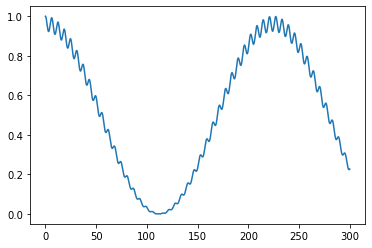

In [45]:
#large time. The occupation decay to 0 as predicted.
#I'm guessing this is caused by the system size being too small
dynamics(H_dynamics, v_single_corner, 0.1, 3001, number_op(21,2**5))

In [ ]:
#Bulk

In [17]:
v_single_bulk = np.zeros(2**16)
v_single_bulk[0] = 1 
v_single_bulk = np.kron(v_single_bulk, ψ)
v_single_bulk = construct_majorana_operator(lattsize, (2,2), MajoranaType.Re).dot(v_single_bulk)
np.vdot(v_single_bulk, number_op(21,2**10).dot(v_single_bulk))

(1.0000000000000002+0j)

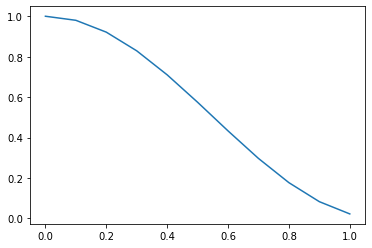

In [38]:
dynamics(H_dynamics, v_single_bulk, 0.1, 11, number_op(21,2**10))
#the occupation decay fast.

In [33]:
#put the dynamics of bulk and edge togther to have a comparision.
def dynamics_compare(H, v1, v2, dτ, nsteps, numberoprator1, numberoprator2):
    
    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)
    
    for v in [v1, v2]:
        assert np.linalg.norm(R1.dot(v) - v) < 1e-10
        assert np.linalg.norm(R2.dot(v) - v) < 1e-10
        assert np.linalg.norm(R3.dot(v) - v) < 1e-10
        assert np.linalg.norm(R4.dot(v) - v) < 1e-10
        
    num_traj1 = np.zeros(nsteps)
    num_traj1[0] = np.vdot(v1,  numberoprator1.dot(v1)).real
    for n in range(1, nsteps):
        v1 = spla.expm_multiply(-(1j)*(dτ)*H, v1)
        v1 /= np.linalg.norm(v1)
        num_traj1[n] = np.vdot((v1),  numberoprator1.dot(v1)).real
        
    num_traj2 = np.zeros(nsteps)
    num_traj2[0] = np.vdot(v2,  numberoprator2.dot(v2)).real
    for n in range(1, nsteps):
        v2 = spla.expm_multiply(-(1j)*(dτ)*H, v2)
        v2 /= np.linalg.norm(v2)
        num_traj2[n] = np.vdot((v2),  numberoprator2.dot(v2)).real
        
    for v in [v1, v2]:
        assert np.linalg.norm(R1.dot(v) - v) < 1e-10
        assert np.linalg.norm(R2.dot(v) - v) < 1e-10
        assert np.linalg.norm(R3.dot(v) - v) < 1e-10
        assert np.linalg.norm(R4.dot(v) - v) < 1e-10
        
    plt.plot(dτ*np.arange(nsteps), num_traj1, label="corner")
    plt.plot(dτ*np.arange(nsteps), num_traj2, label="bulk")
    plt.xlabel("time")
    plt.ylabel("<n>")
    plt.show()
        
    
    

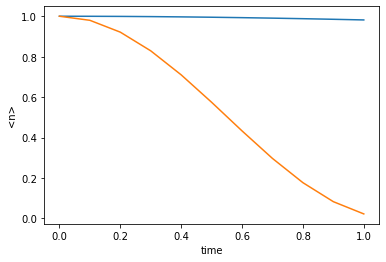

In [35]:
dynamics_compare(H_dynamics, v_single_corner, v_single_bulk, 0.1, 11, number_op(21,2**5), number_op(21,2**10))
#compare in small time.
#Blue: edge
#red: bulk

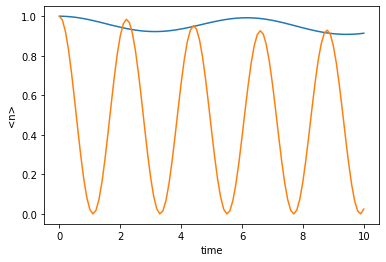

In [36]:
dynamics_compare(H_dynamics, v_single_corner, v_single_bulk, 0.1, 101, number_op(21,2**5), number_op(21,2**10))
#compare in longer time.
#Blue: edge
#red: bulk